In [259]:
from __future__ import print_function, division, unicode_literals
import six
import os
from os.path import join
import json
from codecs import open
from collections import defaultdict
from operator import itemgetter
import nltk
import numpy as np
from nltk.corpus import stopwords
import re
import codecs

from sklearn.cross_validation import KFold

In [324]:
DATA_DIR = join(os.environ['HOME'], 'data/allen-ai-challenge')
# LUCENE_FILE = join(DATA_DIR, 'features', 'lucene_vecs10.tsv')
LUCENE_FILE = join(DATA_DIR, 'features', 'lucene_vecs10_submission.tsv')
W2V_FILE = join(DATA_DIR, 'features', 'w2f_validate.tsv')
# W2V_FILE = join(DATA_DIR, 'features', 'w2f.tsv')
SUMBISSION_FILE = join(DATA_DIR, 'submissions', 'weights.csv')

In [325]:
import theano
import theano.tensor as T

In [326]:
all_x = []
all_y = []
all_qid = []
with open(LUCENE_FILE, encoding='utf8') as f:
    for row in (line.strip().split('\t') for line in f):
        all_qid.append(row[0])
        correct = row[1]
        vecs = np.vstack([np.fromstring(r, sep=';') for r in row[2:6]])
        
        all_x.append(vecs)
        y_vec = np.zeros(4, dtype=int)
        if correct in 'ABCD':
             y_vec['ABCD'.index(correct)] = 1
        all_y.append(y_vec)
all_x = np.array(all_x)
all_y = np.array(all_y)


W2V = []
with open(W2V_FILE, encoding='utf8') as f:
    for row in (line.strip().split('\t') for line in f):
        qid = row[0]
        w2v = np.array([float(w) for w in row[3:7]])
        W2V.append(w2v)
W2V = np.array(W2V)


In [327]:
idx_train, idx_valid = next(iter(KFold(all_x.shape[0], 10, shuffle=True)))
print(all_x.shape)
print(W2V.shape)

(8132, 4, 10)
(8132, 4)


In [321]:
import lasagne
D = all_x.shape[2]

lin = lasagne.layers.InputLayer((None, D))
n = lasagne.layers.DenseLayer(lin, 1, W=lasagne.init.Constant(1), b=None, nonlinearity=lasagne.nonlinearities.elu)
n = lasagne.layers.ReshapeLayer(n, (-1, 4))
n = lasagne.layers.DenseLayer(n, 4, nonlinearity=lasagne.nonlinearities.softmax)
output = lasagne.layers.get_output(n)
params = lasagne.layers.get_all_params(n)

var_targets = T.imatrix()
t_nll = lasagne.objectives.categorical_crossentropy(output, var_targets).mean()
t_acc = lasagne.objectives.categorical_accuracy(output, var_targets).mean()
updates = lasagne.updates.adam(t_nll, params)

train_fn = theano.function([lin.input_var, var_targets], t_nll, updates=updates)
cost_fn = theano.function([lin.input_var, var_targets], t_nll)
acc_fn = theano.function([lin.input_var, var_targets], t_acc)
forward_fn = theano.function([lin.input_var], output)

In [322]:
def randomize(x, y):
    new_x = np.zeros((x.shape[0] * 4, x.shape[2]))
    new_y = np.zeros_like(y)
    for i in range(x.shape[0]):
        keys = np.arange(4)
        np.random.shuffle(keys)
        for j, k in enumerate(keys):
            new_x[i*4 + k] = x[i, j]
            new_y[i, k] = y[i, j]
    return new_x, new_y.astype('int32')

BATCH = 50
for e in range(200):
    np.random.shuffle(idx_train)
    for i in range(0, idx_train.shape[0], 50):
        keys = idx_train[i:i+BATCH]
        batch_x = all_x[keys]
        batch_y = all_y[keys]
        bx, by = randomize(batch_x, batch_y)
        loss = train_fn(bx, by)
#         print(loss)
    bx, by = randomize(all_x[idx_valid], all_y[idx_valid])
    print(e, cost_fn(bx, by), acc_fn(bx, by))

0 17.2916406148 0.268
1 13.1499603825 0.256
2 7.61889781886 0.312
3 6.03041910125 0.264
4 5.15571808975 0.324
5 4.71106213386 0.276
6 4.72831687582 0.232
7 4.45231680088 0.284
8 4.44721931681 0.26
9 4.35181475437 0.256
10 3.85991754967 0.252
11 3.88963293057 0.264
12 3.7438041262 0.24
13 3.65417397382 0.256
14 3.51540393906 0.236
15 3.17234705819 0.268
16 2.98123262204 0.272
17 2.92512431018 0.248
18 2.71557414135 0.28
19 2.71568380625 0.284
20 2.56966616348 0.252
21 2.41766397523 0.264
22 2.20391710301 0.264
23 2.1008605649 0.284
24 2.09017455125 0.268
25 2.07286701913 0.256
26 1.94620630225 0.24
27 1.89018009233 0.272
28 1.78389778776 0.264
29 1.63572839541 0.28
30 1.61698301888 0.304
31 1.63979773489 0.232
32 1.56991281193 0.236
33 1.53647131419 0.244
34 1.48595666583 0.308
35 1.47747784817 0.252
36 1.44066229467 0.28
37 1.41440299569 0.252
38 1.39950350571 0.316
39 1.37970536869 0.292
40 1.42288181128 0.216
41 1.39013872368 0.272
42 1.37555656449 0.3
43 1.37583983408 0.276
44 1.399

In [323]:
W = params[0].get_value()[:,0]
# W = np.ones_like(W)
# W[0] = 2
print(W)

def norm_softmax(data, mult=1):
    s = data.sum(axis=1, keepdims=True)
    normalized = data/s * mult
    exps = np.exp(normalized)
    return exps / exps.sum(axis=1, keepdims=True) 


[ 0.6307913   0.3830684   0.26365166  0.20653428  0.15964845  0.10003289
  0.06163429  0.0283954   0.00352024 -0.01215039]


In [257]:
res = []
bx, by = randomize(all_x, all_y)

lucene_output = np.dot(all_x, W)
lucene_output = np.exp(lucene_output)
lucene_output = lucene_output / lucene_output.sum(axis=1, keepdims=1)
for gamma  in np.linspace(0, 1, 100):
    overall_output = norm_softmax(lucene_output)*gamma + norm_softmax(W2V)*(1-gamma)
    print(gamma, 'Overall accuracy', (all_y.argmax(axis=1) == overall_output.argmax(axis=1)).sum() / all_y.shape[0])
    acc = (all_y.argmax(axis=1) == overall_output.argmax(axis=1)).sum() / all_y.shape[0]
    res.append(acc)



0.0 Overall accuracy 0.3768
0.010101010101 Overall accuracy 0.3864
0.020202020202 Overall accuracy 0.3948
0.030303030303 Overall accuracy 0.3984
0.040404040404 Overall accuracy 0.4044
0.0505050505051 Overall accuracy 0.416
0.0606060606061 Overall accuracy 0.4188
0.0707070707071 Overall accuracy 0.4192
0.0808080808081 Overall accuracy 0.4236
0.0909090909091 Overall accuracy 0.43
0.10101010101 Overall accuracy 0.4352
0.111111111111 Overall accuracy 0.436
0.121212121212 Overall accuracy 0.438
0.131313131313 Overall accuracy 0.4408
0.141414141414 Overall accuracy 0.4408
0.151515151515 Overall accuracy 0.4408
0.161616161616 Overall accuracy 0.444
0.171717171717 Overall accuracy 0.4436
0.181818181818 Overall accuracy 0.444
0.191919191919 Overall accuracy 0.444
0.20202020202 Overall accuracy 0.4472
0.212121212121 Overall accuracy 0.4484
0.222222222222 Overall accuracy 0.4484
0.232323232323 Overall accuracy 0.4496
0.242424242424 Overall accuracy 0.4484
0.252525252525 Overall accuracy 0.4488
0.

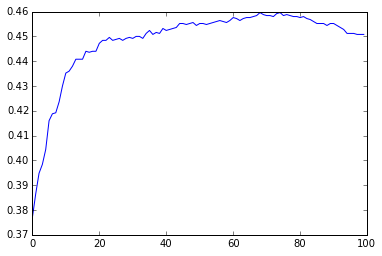

In [258]:
%matplotlib inline
from matplotlib.pyplot import *

plot(res)

In [283]:
bx.shape[0]

32528

In [329]:
res = []
bx, by = randomize(all_x, all_y)

lucene_output = np.dot(all_x, W)
lucene_output = np.exp(lucene_output)
lucene_output = lucene_output / lucene_output.sum(axis=1, keepdims=1)

gamma = 0.75
overall_output = norm_softmax(lucene_output)*gamma + norm_softmax(W2V)*(1-gamma)
overall_answers = overall_output.argmax(axis=1)

SUMBISSION_FILE = join(DATA_DIR, 'submissions', 'weights.csv')

with open(SUMBISSION_FILE, mode='w') as f:
    print('id,correctAnswer', file=f)
    for i in range(by.shape[0]):
        print(all_qid[i], 'ABCD'[overall_answers[i]], sep=',', file=f)